In [1]:
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

import film as film_mod
import design as design_mod
import spectrum as spec_mod
from optimizer.adam import AdamThicknessOptimizer
from utils.loss import calculate_RMS_f_spec

from analyze_utils.make_design import make_reflection_design

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

from analyze_utils.structure import plot_layer_thickness
from utils.loss import calculate_RMS_f_spec, calculate_RMS
from utils.get_n import get_n_SiO2, get_n_TiO2
import matplotlib.cm as cmap


## Different OT - Bragg structure

In [ ]:
def make_rand_new_film_dif_gt(gt):
    layers = 200
    d = np.random.random(layers) * gt / layers * 2 # smaller ot allows for fewer configurations
    film = film_mod.TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', d)
    return film

design = make_reflection_design(make_rand_new_film_dif_gt(0))
target: list[spec_mod.BaseSpectrum] = design.target_specs

rep = 50
gts = np.linspace(200, 5000, 20)
loss_rep_ls = []
film_rep_ls = []
for rep_i in range(rep):
    loss_ls = []
    film_ls = []
    print(rep_i / rep)
    for gt in gts:
        adam_optimizer = AdamThicknessOptimizer(
            make_rand_new_film_dif_gt(gt), 
            target, 
            500, 
            alpha=1, 
            show=False, 
            record=True, 
        )
        films, losses = adam_optimizer()
        loss_ls.append(losses)
        film_ls.append(films)
    loss_rep_ls.append(loss_ls)
    film_rep_ls.append(film_ls)

working_file = './gts'
with open(working_file, 'wb') as file:
    pickle.dump({'film': film_rep_ls, 'loss': loss_rep_ls}, file)

In [ ]:
with open(working_file, 'rb') as file:
    res = pickle.load(file)
    film_rep_ls = res['film']
    loss_rep_ls = res['loss']

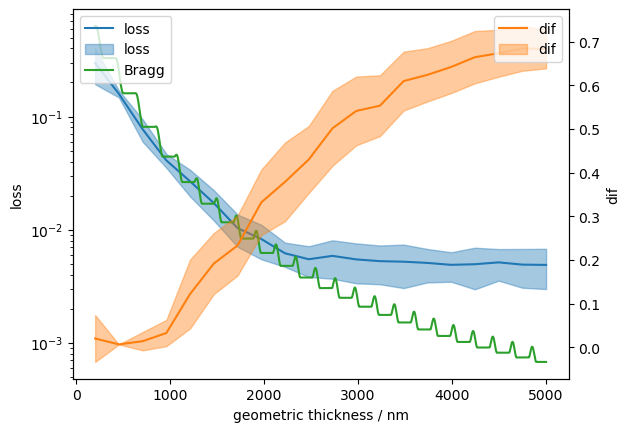

In [ ]:

def calculate_dif_Bragg(film: film_mod.TwoMaterialFilm, dA, dB):
    # NOTE: film keeps the material of the first layer in remove negative layers.
    # The first layer is SiO2.
    d = film.get_d()
    dif = 0
    for i, di in enumerate(d):
        dif += min(abs(di - [dA, dB][i % 2]), abs(di - 0))
    return dif / d.sum()

def plot_rep(ax, x, arr, label):
    arr_mean = arr.mean(axis=0)
    arr_std = arr.std(axis=0)
    
    c = next(c_gen)
    ax.plot(x, arr_mean, label=label, c=c)
    ax.fill_between(x, arr_mean - arr_std, arr_mean + arr_std, label=label, alpha=0.4, color=c)
    return ax

# make reference: DBR
def loss_DBR(gt):
    d_tot = 0
    i = 0
    while True:
        this_d = [d_TiO2, d_SiO2][i % 2]
        d_tot += this_d
        if d_tot > gt:
            break
        i += 1
    last_d = this_d - (d_tot - gt)
    d = np.array([d_TiO2, d_SiO2] * (i // 2) + [d_TiO2] * (i % 2) + [last_d])
    film = film_mod.TwoMaterialFilm('TiO2', 'SiO2', 'SiO2', d)
    return calculate_RMS_f_spec(film, target)

def color():
    i = 0
    while True:
        yield f'C{i}'
        i += 1




loss_rep_arr = np.array([[l[-1] for l in rep] for rep in loss_rep_ls])

wl = 800.
d_SiO2 = wl / 4 / get_n_SiO2(wl)
d_TiO2 = wl / 4 / get_n_TiO2(wl)

dif = []
for films in film_rep_ls:
    dif.append([])
    for film in [f[-1] for f in films]:
        film.remove_negative_thickness_layer()
        # plot_thickness_idx(film)
        # print(calculate_RMS_f_spec(film, target))

        dif[-1].append(calculate_dif_Bragg(film, d_SiO2, d_TiO2))
dif = np.array(dif)

c_gen = color()
fig, ax = plt.subplots(1, 1)
plot_rep(ax, gts, loss_rep_arr, 'loss')
gts_dense = np.linspace(gts[0], gts[-1], 1000)
ax.plot(gts_dense, [loss_DBR(gt) for gt in gts_dense], label='Bragg', c='C2')
ax.set_ylabel('loss')
ax.legend(loc='upper left')
ax.set_xlabel('geometric thickness / nm')
ax.set_yscale('log')

ax2 = plot_rep(ax.twinx(), gts, dif, 'dif')
ax2.set_ylabel('dif')
ax2.legend(loc='upper right')
# ax2.set_yscale('log')
